$\textbf{Rover Analytics Project}$ <br>
Ryan Peabody <br>
831.332.4107 <br>
ryanjamespeabody@gmail.com <br>
January 14, 2018

The following Jupyter notebook contains my work on and answers to the questions posed in the Rover analytics assignment. The work was done in Python, interfacing with the SQL database through Pandas. The code is annotated, but it is possible to follow along only reading the formatted markdown cells.

Let's start by importing some standard packages to analyze and visualize the data

In [43]:
import sqlite3
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime as dt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns;
sns.set(color_codes = True)

And establish a connection to the SQLite database

In [44]:
conn = sqlite3.connect('db26.sqlite3')

<br>
$$\textbf{Section I. Exploring the database}$$
<br>
We begin by asking a few basic questions about the users of this platform.
<br>

**1) How many users have signed up?**

In [45]:
# Count the number of rows in people_person, as each
query = '''
    SELECT 
    COUNT(*) 
    AS 'Total sign-ups'
    FROM people_person;
'''
display(pd.read_sql(query, conn))

,Total sign-ups
0,64416


<br>
**2) How many users signed up prior to 2017-01-12?**

In [46]:
# Count the number of rows in people_person where the date they joined is before 2017-01-12
query = '''
    SELECT 
    COUNT(*) AS 'Total sign-ups prior to 2017-01-12'
    FROM people_person
    WHERE date_joined < DATETIME('2017-01-12');
'''
display(pd.read_sql(query, conn))

,Total sign-ups prior to 2017-01-12
0,35500


<br>
**3) What percentage of users have added pets?**

In [47]:
# Make two selections and divide them. The first selects all distinct (some owners have multiple pets) owner IDs
# from owner_id. The second selects the total number of users (rows) in people_person

query = '''
    SELECT ROUND(
        (SELECT COUNT(DISTINCT(owner_id)) FROM pets_pet)*100.0
        /
        (SELECT COUNT(*) FROM people_person),
        3)
    AS 'Percentage of users that have added pets (%)';
'''
display(pd.read_sql(query, conn))

,Percentage of users that have added pets (%)
0,80.44


<br>
**4) Of those users, how many pets have they added on average?**

In [48]:
# Count the total number of pets that each owner has, grouping by owner ID. Then average these totals across all users
# who have added pets
query = '''
    SELECT
    ROUND(AVG(pet_count), 3)
    AS 'Average number of pets added'
    FROM
        (
        SELECT COUNT(*) AS pet_count
        FROM pets_pet
        GROUP BY owner_id
        );
'''
display(pd.read_sql(query, conn))

,Average number of pets added
0,1.496


<br>
**5) What percentage of pets play well with cats?**

In [49]:
# Count all the pets in pets_pet where play with cats = 1, and divide that number by the total number of rows
# in pets_pet
query = '''
    SELECT ROUND(
        (SELECT COUNT(*) FROM pets_pet WHERE plays_cats = 1)*100.0
        / 
        (SELECT COUNT(*) FROM pets_pet),
        3)
    AS 'Percentage of pets that play well with cats (%)';
'''
display(pd.read_sql(query, conn))

,Percentage of pets that play well with cats (%)
0,24.776


***

<br>
$$\textbf{Section II. Conversations and bookings}$$
<br>
Some users can offer pet care services. When an owner needs pet care, they can create a conversation with another user that offers the service they are interested in. After exchanging some messages and possibly meeting in person, that conversation hopefully books. In that case, services are paid for and delivered. Occasionally, some conversations that have booked may be cancelled. Lastly, for uncancelled bookings, both owners and sitters have the option of leaving a review.
<br>
<br>

<br>
**1) What are the possible services and what is the average price per unit for each service type?**

In [50]:
# Average price from services_service, grouped by service_type
query = '''
    SELECT service_type AS 'Service type', 
    ROUND(AVG(price), 2) AS 'Price per unit ($)'
    FROM services_service
    GROUP BY service_type;
''' 
display(pd.read_sql(query, conn))


,Service type,Price per unit ($)
0,boarding,34.51
1,day-care,27.01
2,dog-walking,21.98


There are three services offered: boarding, day-care, and dog-walking. They cost \$34.51, \$27.01, and \$21.98 per unit, respectively.

<br>
**2) How many requests have there been for each service type and what percentage of those have booked? The percentage of those that have booked is called booking rate.**

In [51]:
# Count total requests, and total bookings for each service by joining conversations_conversation with 
# services_service. Divide the total bookings by total requests to get booking rate
query = '''
     SELECT 
        service_type AS 'Service type',
        total AS 'Total requests',
        ROUND(booking*100.0 / total, 2) AS 'Booking rate (%)'
    FROM (
        SELECT
            service_type,
            SUM(CASE WHEN booked_at IS NOT NULL THEN 1 ELSE 0 END) AS booking,
            COUNT(*) AS total
        FROM conversations_conversation
        INNER JOIN services_service
            ON conversations_conversation.service_id = services_service.id
        GROUP BY service_type
        );
'''
display(pd.read_sql(query, conn))

,Service type,Total requests,Booking rate (%)
0,boarding,26665,40.74
1,day-care,26362,35.72
2,dog-walking,26716,47.95


Requests for the three services are split relatively evenly: 26,665 requests for boarding, 26,362 requests for day care, and 26,716 requests for dog walking. Booking rates are split more unevenly: 40.74% booking rate for boarding, 35.72% for day care, and 47.95% for dog walking.

<br>
**3) What are the cancellation rates for each service?**

In [52]:
# Count total bookings and total cancellations for each service by joining conversations_conversation with 
# services_service. Divide the total cancellations by the total bookings to get cancellation rate
query = '''
    SELECT 
        service_type AS 'Service type', 
        ROUND(cancellation*100.0 / total, 2) AS 'Cancellation rate (%)'
    FROM (
        SELECT
            service_type,
            SUM(CASE WHEN cancelled_at IS NOT NULL THEN 1 ELSE 0 END) AS cancellation,
            COUNT(*) AS total
        FROM conversations_conversation
        INNER JOIN services_service
            ON conversations_conversation.service_id = services_service.id
        WHERE booked_at != 'None'
        GROUP BY service_type
        )
''' 
display(pd.read_sql(query, conn))

,Service type,Cancellation rate (%)
0,boarding,9.68
1,day-care,9.76
2,dog-walking,9.51


Cancellation rates are split relatively evenly between services: 9.68% cancellation rate for boarding, 9.76% for day care, and 9.51% for dog walking

**4) For uncancelled bookings, is the owner or provider more likely to leave a review and which tends to leave better reviews? How would you narrate this finding to a business partner?**

In [53]:
# Pull out the total number of uncancelled bookings
query = '''
   SELECT
       COUNT(*) AS bookings
   FROM conversations_conversation
   WHERE booked_at IS NOT NULL AND cancelled_at IS NULL;
'''
total_bookings = pd.read_sql(query, conn)
total_bookings = float(total_bookings.bookings)

In [54]:
# Pull out the number of reviews left by owners (where the reviewer ID is the same as the ID that requested the
# service, and their average star rating
query = '''
    SELECT 
        COUNT(*) AS reviews, 
        AVG(stars) AS stars
    FROM(
        SELECT *
        FROM conversations_conversation AS c_c
        INNER JOIN conversations_review AS c_r
            ON c_c.id = c_r.conversation_id
        )
    WHERE requester_id = reviewer_id;
'''
owners = pd.read_sql(query, conn)

In [55]:
# Pull out the number of reviews left by providers (where the reviewer ID is NOT the same as the ID that requested
# the service, and their average star rating
query = '''
    SELECT 
        COUNT(*) AS reviews,
        AVG(stars) AS stars
    FROM(
        SELECT *
        FROM conversations_conversation AS c_c
        INNER JOIN conversations_review AS c_r
            ON c_c.id = c_r.conversation_id
        )
    WHERE requester_id != reviewer_id;
'''
providers = pd.read_sql(query, conn)

In [56]:
# Pull out and display results
reviews = {'Owner review rate (%)': round(owners.reviews*100 / total_bookings, 2),
           'Average owner review': round(owners.stars, 2),
           'Provider review rate (%)': round(providers.reviews*100 / total_bookings, 2),
           'Average provider review': round(providers.stars, 2)}
reviews = pd.DataFrame(reviews, index = [0])
display(reviews)

,Average owner review,Average provider review,Owner review rate (%),Provider review rate (%)
0,4.41,3.89,75.22,20.21


We can see that owners are leaving reviews at a rate three times as high as providers. 75.22% of fulfilled bookings get a review from an owner, while only 20.21% of bookings get a review from the provider. Owners are also leaving significantly more positive reviews than providers, averaging 4.41 and 3.89 stars out of 5, respectively.

In the context of this start-up, the ***providers*** of pet care are both less engaged with the platform, and less positive about the services they are providing than the pet ***owners*** using them. Owners generally leave reviews after a booking, while providers generally do not. When an provider does leave a review, on average it is less favorable than a review left by an owner.

***

<br>
$$\textbf{Section III. Recent daily booking rate}$$
<br>
The snapshot of this database was taken on 2017-07-11 at midnight and only contains data refeclting events prior to that date. A junior analyst is investigating daily booking rate during the days prior to the snapshot and is concerned about an apparent downward trend.
<br>
<br>

**1) First, let's reproduce their results. They tell you that daily booking rate is defined to be the percentage of conversations created each day that eventually book. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?**

Initially, we aren't looking for mechanisms to explain this trend, so we're just going to calculate and select the booking rate by day.

In [57]:
# Select dates on which conversations were started, and count the number of conversations started on each day, as 
# well as the number of bookings resultant from those conversations
query = '''
    SELECT 
        date_started,
        bookings*100.0 / total_conversations AS 'rate'
    FROM (
        SELECT
            SUM(CASE WHEN booked_at != 'None' THEN 1 ELSE 0 END) AS bookings,
            COUNT(*) AS total_conversations,
            DATE(added) AS date_started
        FROM conversations_conversation
        GROUP BY DATE(added)
        );
    '''
daily_booking_rate = pd.read_sql(query, conn)
t = daily_booking_rate.date_started
booking_rate = daily_booking_rate.rate

<p> Let's take an initial look at the back end of this data set, just to get a feel for the numbers

In [58]:
display(daily_booking_rate[-10:])

,date_started,rate
711,2017-07-01,49.466192
712,2017-07-02,45.519713
713,2017-07-03,39.739414
714,2017-07-04,47.482014
715,2017-07-05,42.857143
716,2017-07-06,41.263941
717,2017-07-07,32.733813
718,2017-07-08,24.087591
719,2017-07-09,21.875000
720,2017-07-10,6.206897


On initial inspection, there definitely appears to be a sharp decrease in the days leading up to the snapshot. But we don't know what the normal variability in the booking rate is, nor if the initially reported 90-day trend can be recreated. 

Let's visualize the full time series, as well as the last 90 days, and see what the linear trend is over that period

In [59]:
# Create 90-day time vector
t_num = []
for ii in range(1, 91): t_num.append(ii)

# Fit a first order polynomial function using NumPy
z = np.polyfit(t_num, booking_rate[-90:], 1)
p = np.poly1d(z)

# 14-day moving average of the full time series
window = 14
mva = np.convolve(booking_rate, np.ones((window,))/window, mode='valid')
dt_mva = t[window//2-1 : -window//2]

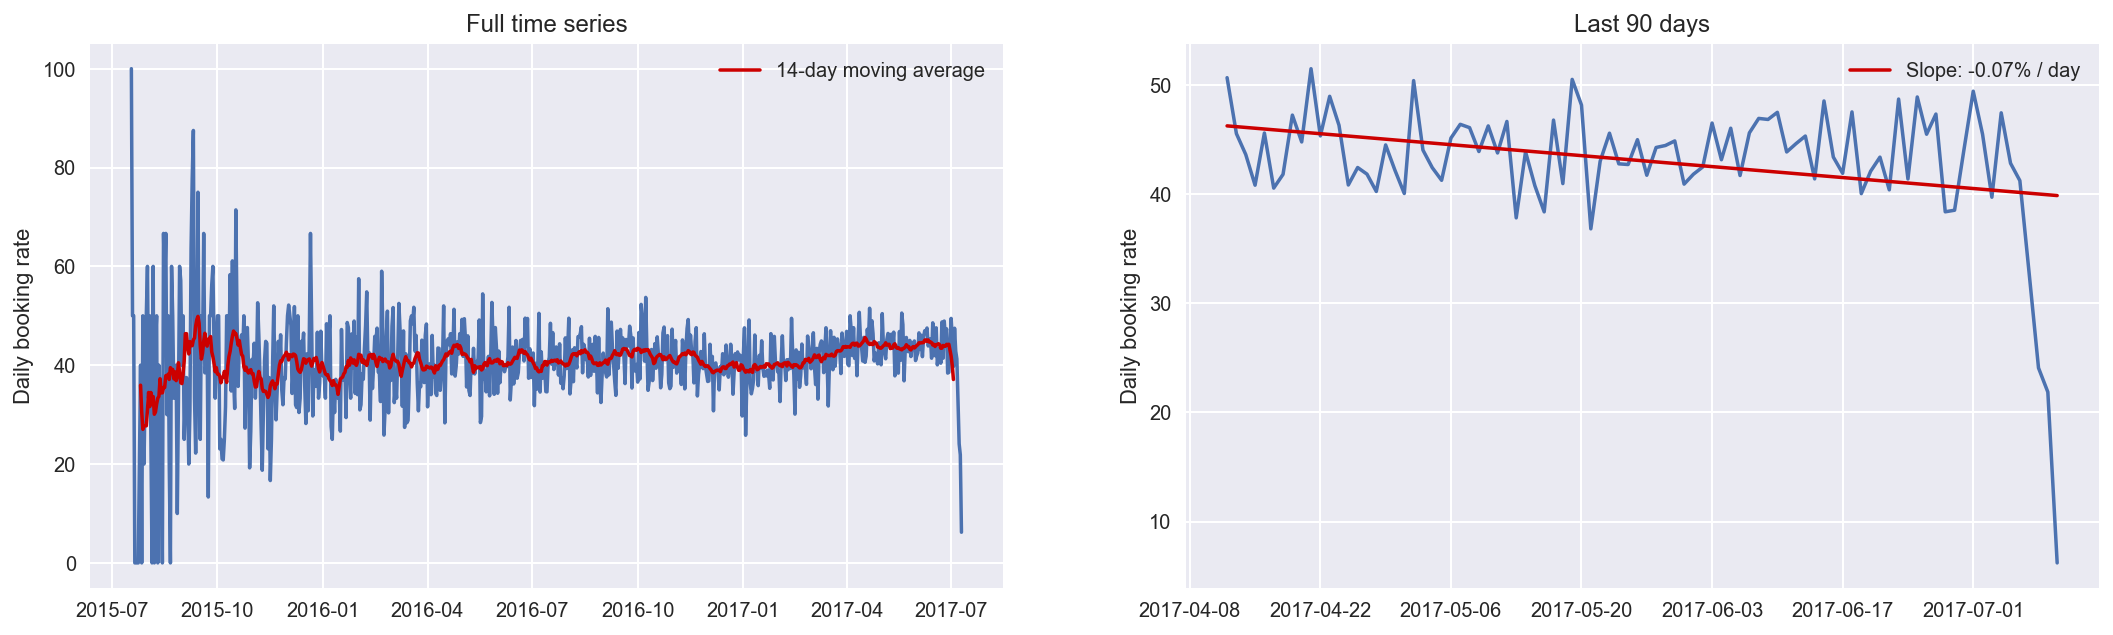

In [60]:
fig, (ax_1, ax_2) = plt.subplots(nrows = 1, ncols = 2)

ax_1.plot_date(t, booking_rate, linestyle = 'solid', marker = 'None')
h = ax_1.plot_date(dt_mva, mva, linestyle = 'solid', marker = 'None', color = (0.8, 0.0, 0.0), 
                   label = '14-day moving average')
ax_1.legend(handles = h)
ax_1.set_title('Full time series')
ax_1.set_ylabel('Daily booking rate')

ax_2.plot_date(t[-90:], booking_rate[-90:], linestyle = 'solid', marker = 'None')
h = ax_2.plot_date(t[-90:], p(t_num), linestyle = 'solid', marker = 'None', color = (0.8, 0.0, 0.0),
                  label = 'Slope: ' + str(round(p[1], 2)) + '% / day')
ax_2.legend(handles = h)
ax_2.set_title('Last 90 days')
ax_2.set_ylabel('Daily booking rate')

fig.set_figheight(5)
fig.set_figwidth(18)
plt.show()

When we examine the two-year time series of daily booking rates, we can see that booking rates were highly variable in the early days of the start-up, but became more stable over time, settling at about 40% for most of 2016. After late 2015, the daily booking rate never dropped below 20%. Over the 90 daysleading up to the July 11, 2017 snapshot, daily booking rates generally fluctuated between 40% and 50%. However, the booking rate dropped to 33% on July 7, 2017 and continued to decrease from there, reaching 6% on July 10, 2017.

It looks like the numbers support the junior analyst's finding.

**2) Can you narrate a reason why this trend exists? Is there a reason to be concerned?**

Daily booking rate is a function of two variables: the number of conversations initiated on a given day, and the number of those conversations that eventually book.

Let's start by looking at how many conversations were initiated on each day

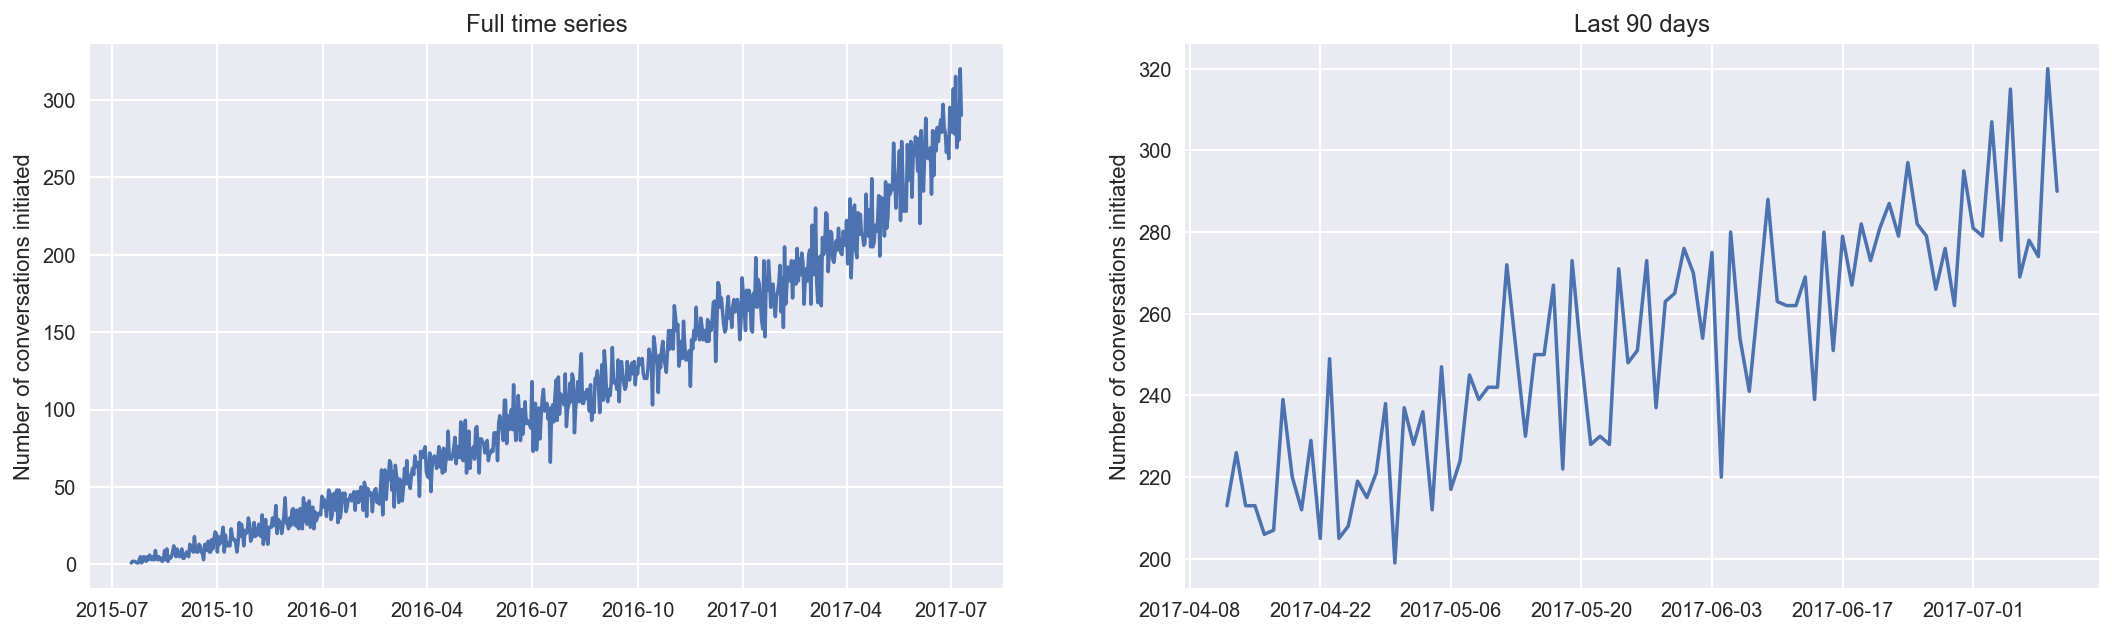

In [61]:
query = '''
    SELECT 
        date_started,
        total_conversations
    FROM (
        SELECT
            SUM(CASE WHEN booked_at != 'None' THEN 1 ELSE 0 END) AS bookings,
            COUNT(*) AS total_conversations,
            DATE(added) AS date_started
        FROM conversations_conversation
        GROUP BY DATE(added)
        );
    '''
conversations = pd.read_sql(query, conn)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

fig, (ax_1, ax_2) = plt.subplots(nrows = 1, ncols = 2)

ax_1.plot_date(conversations.date_started, conversations.total_conversations, linestyle = 'solid', marker = 'None')
ax_1.set_title('Full time series')
ax_1.set_ylabel('Number of conversations initiated')

ax_2.plot_date(t[-90:], conversations.total_conversations[-90:], linestyle = 'solid', marker = 'None')
ax_2.set_title('Last 90 days')
ax_2.set_ylabel('Number of conversations initiated')

fig.set_figheight(5)
fig.set_figwidth(18)
plt.show()

The number of conversations initiated on each day has been steadily increasing over the entire time period, and there is no change in the number of initiated conversations before the snapshot that could explain the decrease in booking rate. The driving mechanism of the decrease must be the number of bookings. Let's pull those out and look at them.

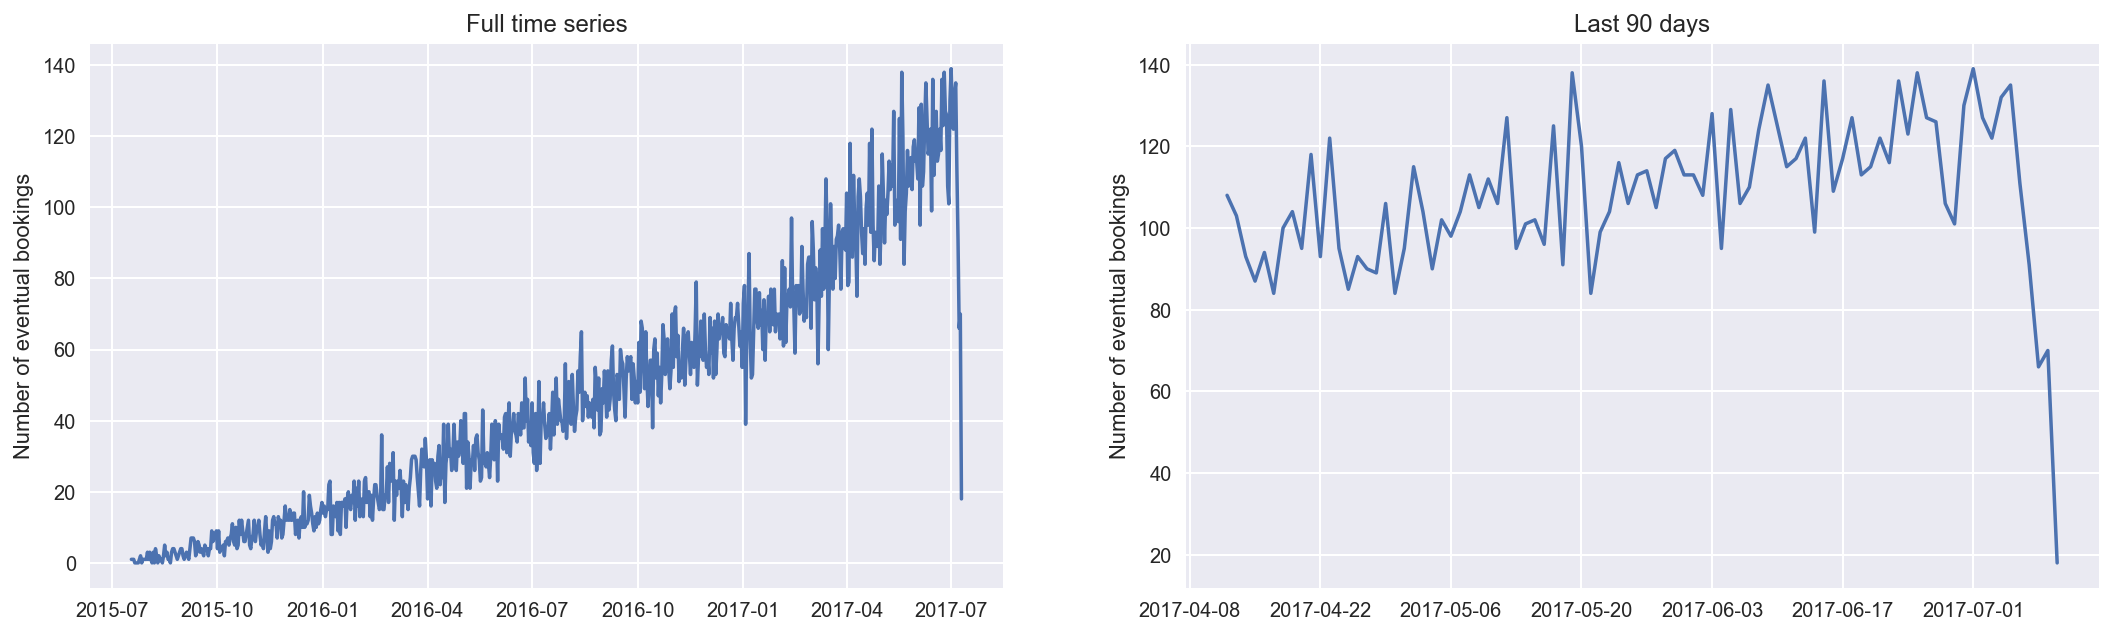

In [62]:
query = '''
    SELECT 
        date_started,
        bookings
    FROM (
        SELECT
            SUM(CASE WHEN booked_at != 'None' THEN 1 ELSE 0 END) AS bookings,
            COUNT(*) AS total_conversations,
            DATE(added) AS date_started
        FROM conversations_conversation
        GROUP BY DATE(added)
        );
    '''
bookings = pd.read_sql(query, conn)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

fig, (ax_1, ax_2) = plt.subplots(nrows = 1, ncols = 2)

ax_1.plot_date(bookings.date_started, bookings.bookings, linestyle = 'solid', marker = 'None')
ax_1.set_title('Full time series')
ax_1.set_ylabel('Number of eventual bookings')

ax_2.plot_date(t[-90:], bookings.bookings[-90:], linestyle = 'solid', marker = 'None')
ax_2.set_title('Last 90 days')
ax_2.set_ylabel('Number of eventual bookings')

fig.set_figheight(5)
fig.set_figwidth(18)
plt.show()

A decrease in bookings is definitely driving the decrease in booking rates. But why is this? Nothing we've seen so far has indicated that this start-up was doing anything *except* increase the number of users and bookings. Of course, it's always possible that some sort of external forcing drove this decrease. Servers going down, or some sort of controversy could have either prevented users from booking, or changed their minds about using the service. However, there is no need to invoke external mechanisms when we still have not fully explored the data.

How does a pet owner book services on this site? They initiate a conversation with a provider, and at some later time that conversation turns into a booking. So there is a lag time between the conversation initiating and the completion of the booking. Let's look into what that lag time is.

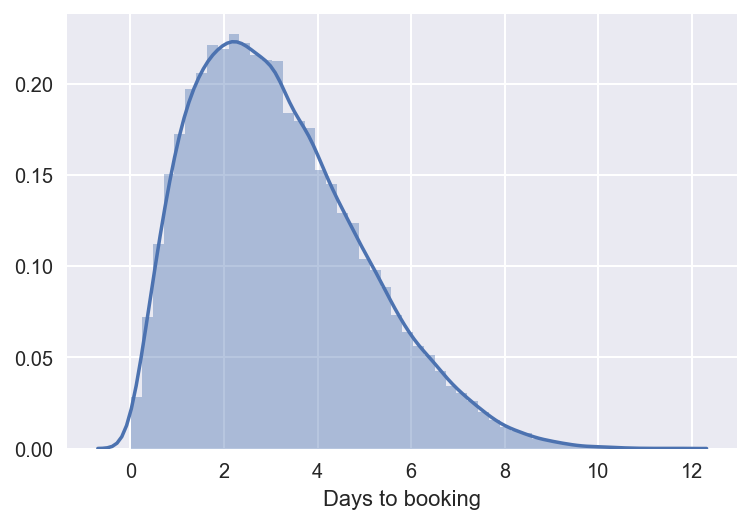

Mean: 3.17 Median: 2.92 Std: 1.79


In [63]:
query = '''
    SELECT 
        DATE(added) AS date_started,
        JULIANDAY(booked_at) - JULIANDAY(added) AS days_to_booking
    FROM conversations_conversation
    WHERE booked_at != 'None'
    ORDER BY DATE(added)
    '''
booking_time = pd.read_sql(query, conn)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

ax = sns.distplot(booking_time.days_to_booking)
ax.set(xlabel = 'Days to booking')
plt.show()

print('Mean: ' + str(round(np.mean(booking_time.days_to_booking), 2)),
      'Median: ' + str(round(np.median(booking_time.days_to_booking), 2)),
      'Std: ' + str(round(np.std(booking_time.days_to_booking), 2)))

So it looks like the average time to booking is just over three days. Our decrease in bookings and booking rate is only evident in the last four days of the snapshot, and also decrease progressively toward zero from the normal range. It is likely that this decrease in booking rate is just a reflection of the lag between the start of conversations and their eventual booking. To test this, let's take an artificial 30-day snapshot on Deceber 31, 2016 of total bookings.

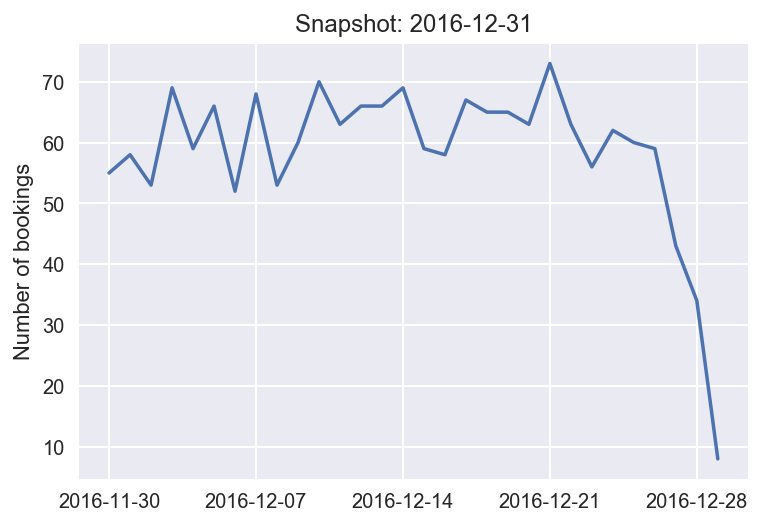

In [64]:
query = '''
    SELECT
        date_started,
        bookings
    FROM (
        SELECT
            SUM(CASE WHEN booked_at != 'None' THEN 1 ELSE 0 END) AS bookings,
            COUNT(*) AS total_conversations,
            DATE(added) AS date_started
        FROM conversations_conversation
        WHERE booked_at < DATETIME('2016-12-31')
        GROUP BY DATE(added)
        );
    '''
snapshot = pd.read_sql(query, conn)

fig = plt.plot_date(snapshot.date_started[-30:], snapshot.bookings[-30:], linestyle = 'solid', marker = 'None')
plt.title('Snapshot: 2016-12-31')
plt.ylabel('Number of bookings')
plt.show()

Same result. The lag between the initiation of a conversation and the eventual booking results in an apparent decrease in bookings over a period of about 3-4 days before the snapshot was taken. It is definitely worth tracking changes in booking rate over time, but the rapid decline observed in July, 2017 is likely not due to any change in user behaviors or site use.

***

<br>
<br>
$$\textbf{Section IV. Analyzing Take Rate}$$

In order to do the next exercise, you will need to understand the fee structure for this company. Each user has a fee associated with their account (recorded on people_person ). If that user books as an owner, the company charges a service fee (in addition to the booking total) that is a percentage of the booking total (to a maximum of \$50). Also, each service has a fee amount (recorded on services_service ). Before a provider receives their payment, the company takes a percentage of the booking total as dictated by that fee. As an example, suppose an owner has a fee amount of 5 percent and books with a service that has a fee amount of 15 percent. If the booking was for \$100, then the owner would get charged \$105 (adding the owner’s fee). The \$5 owner fee would go to the company. An additional \$15 would also go to the company since the service had a 15 percent fee associated to it. The remaining $85 would go to the provider.
<br>
<br>


1) In each month, what were the gross billings and net revenue?

Let's calculate this in as an SQL query

In [65]:
# Join services_service to conversations_conversation for booked and uncancelled services on service ID, and join 
# people_person to  conversations_conversation on requester ID. Use the associated fees from each joined table to 
# calculate gross billing and net revenue for each transaction. Then sum these, grouped on each month. We will 
# remove the day value from each date and replace it with 15, a mid-month filler value
query = '''
    SELECT
        DATE(strftime("%Y-%m-15", booked_at)) as date,
        SUM(booking_total + owner_fee) AS gross_billing,
        SUM(service_fee + owner_fee) AS net_revenue
    FROM(
        SELECT
            booked_at,
            booking_total,
            booking_total * s_s.fee AS service_fee,
            CASE
                WHEN booking_total * p_p.fee < 50 THEN booking_total * p_p.fee 
                ELSE 50 
            END AS owner_fee
        FROM conversations_conversation AS c_c
        LEFT JOIN services_service AS s_s
            ON c_c.service_id = s_s.id
        LEFT JOIN people_person AS p_p
            ON c_c.requester_id = p_p.id
        WHERE booked_at IS NOT NULL
        AND cancelled_at IS NULL
        )
    GROUP BY date;
'''
gb_nr = pd.read_sql(query, conn)

Now, let's plot monthly gross billings and net revenue, and display the values.

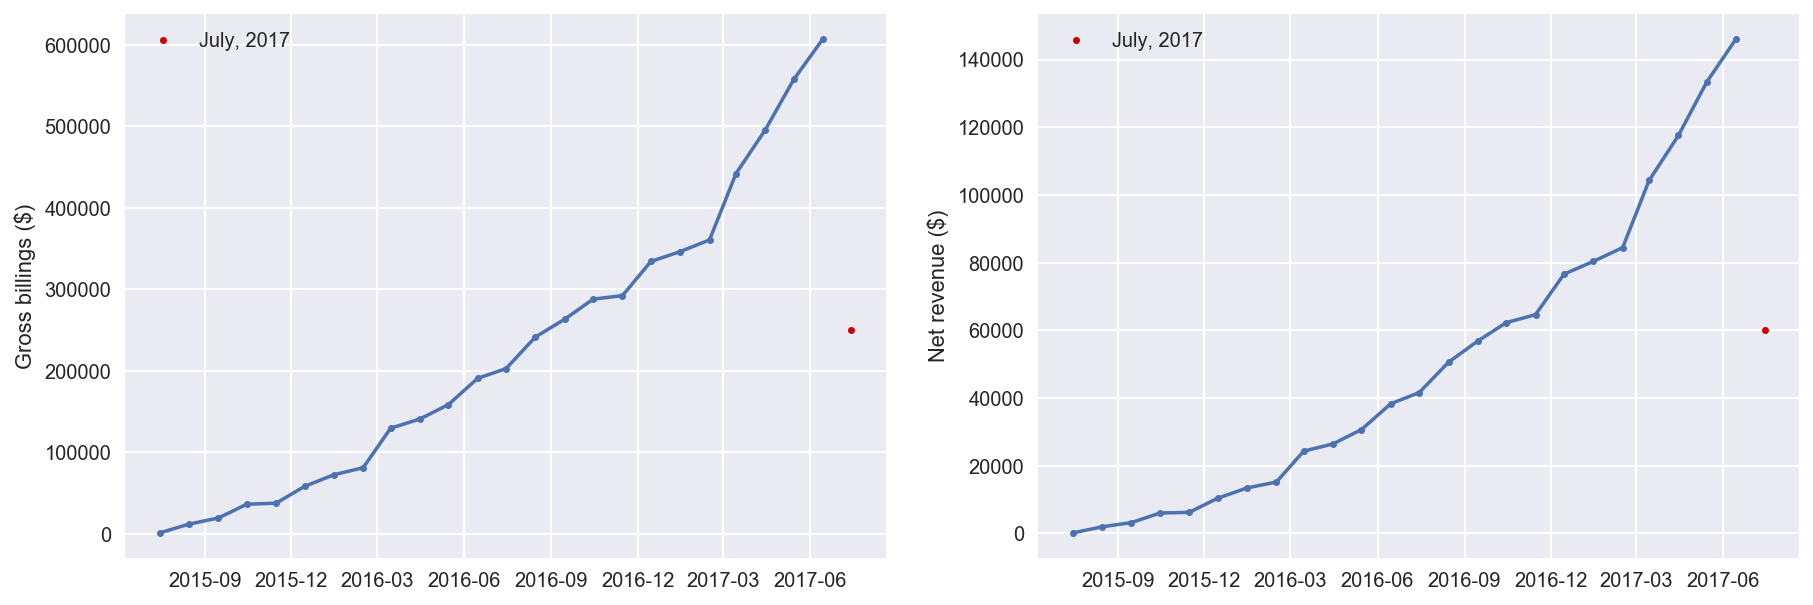

,date,gross_billing,net_revenue
0,2015-07-15,1055.70,175.95
1,2015-08-15,11853.42,1975.57
2,2015-09-15,19318.80,3219.80
3,2015-10-15,36275.28,6045.88
4,2015-11-15,37483.98,6247.33
5,2015-12-15,58121.94,10395.29
6,2016-01-15,72364.38,13450.03
7,2016-02-15,81068.27,15187.32
8,2016-03-15,129518.40,24320.70
9,2016-04-15,140826.95,26476.45


In [66]:
fig, (ax_1, ax_2) = plt.subplots(nrows = 1, ncols = 2)

ax_1.plot_date(gb_nr.date[:-1], gb_nr.gross_billing[:-1], linestyle = 'solid', marker = '.')
h = ax_1.plot_date(gb_nr.date[-1:], gb_nr.gross_billing[-1:], linestyle = 'None', marker = '.', 
                     color = (0.8, 0.0, 0.0), label = 'July, 2017')
ax_1.legend(handles = h)
ax_1.set_ylabel('Gross billings ($)')

ax_2.plot_date(gb_nr.date[:-1], gb_nr.net_revenue[:-1], linestyle = 'solid', marker = '.')
h = ax_2.plot_date(gb_nr.date[-1:], gb_nr.net_revenue[-1:], linestyle = 'None', marker = '.', 
                     color = (0.8, 0.0, 0.0), label = 'July, 2017')
ax_2.legend(handles = h)
ax_2.set_ylabel('Net revenue ($)')

fig.set_figheight(5)
fig.set_figwidth(15)
plt.show()
display(gb_nr)

Both gross billings and net revenue have been increasing steadily over the entire time period, reaching over \$600,000 and \$140,000 respectively in June, 2017. July, 2017 (in red) only representes gross billings and net revenue for the first ten days of the month. Values are the sum of the 1st to the last day of each month, but are plotted on the 15th of each month.

2) Define take rate to be the percentage of gross billings that is net revenue. In the previous example, the take rate is slightly more than 19% since \$20/\$105 is approximately 0.1905. In each month, what was the aggregate take rate?

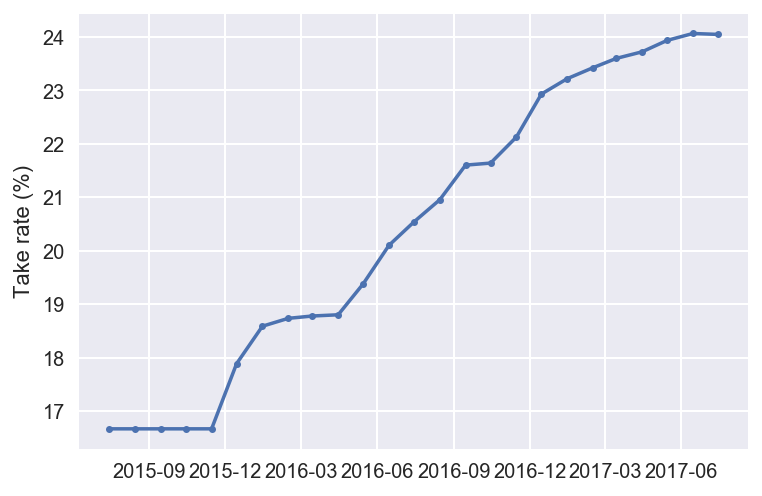

,date,take_rate
0,2015-07-15,16.666667
1,2015-08-15,16.666667
2,2015-09-15,16.666667
3,2015-10-15,16.666667
4,2015-11-15,16.666667
5,2015-12-15,17.885311
6,2016-01-15,18.586534
7,2016-02-15,18.733988
8,2016-03-15,18.777795
9,2016-04-15,18.800698


In [67]:
# Calculate monthly take rate
tr = pd.DataFrame(columns = ['date', 'take_rate'])
tr.date = gb_nr.date
tr.take_rate = [nr*100.0/gb for gb, nr in zip(gb_nr.gross_billing, gb_nr.net_revenue)]

# Plot monthly take rate
fig = plt.plot_date(tr.date, tr.take_rate, linestyle = 'solid', marker = '.')
plt.ylabel('Take rate (%)')
plt.show()

# Display take rate data
display(tr)

3) Did take rate trend up or trend down or remain unchanged over time?

It's pretty obvious just from looking at our graph of take rate that it's been increasing, but let's go ahead and see just how fast. We'll fit a linear model to the monthly data. Months have different lengths, so we can't just use a 1:25 time vector like we did for our daily booking rate data. We have to use the actual number of days.

In [68]:
t_num = []
for ii in tr.date:
    t_num.append(dt.toordinal(dt.strptime(ii, '%Y-%m-%d')))

Now we can fit a linear model

In [69]:
z = np.polyfit(t_num, tr.take_rate, 1)
p = np.poly1d(z)

And plot it

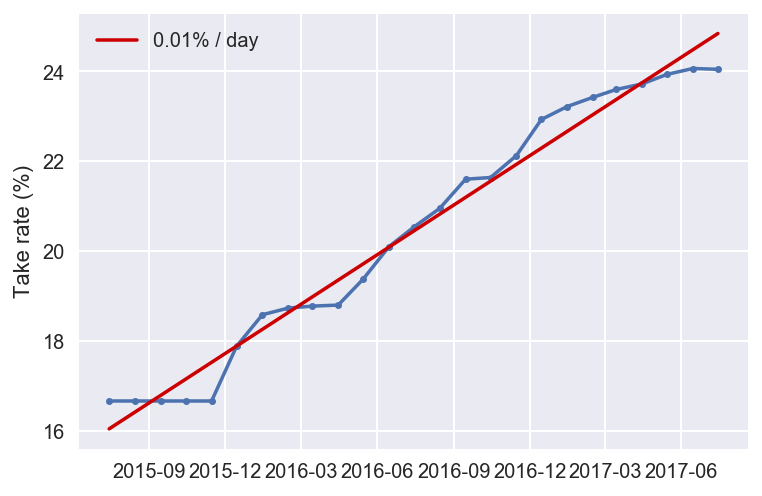

In [70]:
plt.plot_date(tr.date, tr.take_rate, linestyle = 'solid', marker = '.')
h = plt.plot_date(tr.date, p(t_num), linestyle = 'solid', marker = 'None', color = (0.8, 0.0, 0.0),
                 label = str(round(p[1], 2)) + '% / day')
plt.ylabel('Take rate (%)')
plt.legend(handles = h)

plt.show()

On average, take rate increased by 0.012% per day. However, this increase was not always linear. Periods of little change, as well as periods of rapid change are apparent. It is worth noting that monthly take rate never decreased, outside of a *very* small decrease from June to July, 2017. 

4) If it did change, investigate why and provide an explaination. Be sure to
provide additional data/charts/evidence that justify your explaination. Any claims should be backed by data.

Let's take a look at what goes into take rate

$$ Net \: revenue = (Booking \: total)*(Owner \: fee) + (Booking \: total)*(Service \: fee) $$
$$Net \: revenue = (Booking \: total)*[(Owner \: fee) + (Service \: fee)]$$

$$ Gross \: billings = Booking \: total + (Booking \: total)*(Owner \: fee)$$
$$Gross \: billings = (Booking \: total)*[1 + (Owner \: fee)]$$

<br>

$$Take\:Rate = \frac{Net \: revenue}{Gross \: billings}$$

$$Take\:Rate = \frac{(Booking \: total)*[(Owner \: fee) + (Service \: fee)]}{(Booking \: total)*[1 + (Owner \: fee)]}$$

$$Take\:Rate = \frac{(Owner \: fee) + (Service \: fee)}{1 + (Owner \: fee)}$$

By definition, take rate only varies with the service fee (%) and owner fee (%). Let's see how those have changed take rate over time. We can take the original SQL query from this section, and modify it to pull out the average owner and service fees by month

In [71]:
query = '''
    SELECT
        DATE(strftime("%Y-%m-15", booked_at)) as date,
        SUM(booking_total + owner_fee) AS gross_billing,
        SUM(service_fee + owner_fee) AS net_revenue,
        AVG(service_pct) AS service_pct,
        AVG(owner_pct) AS owner_pct
    FROM(
        SELECT
            booked_at,
            booking_total,
            booking_total * s_s.fee AS service_fee,
            s_s.fee AS service_pct,
            p_p.fee AS owner_pct,
            CASE
                WHEN booking_total * p_p.fee < 50 THEN booking_total * p_p.fee 
                ELSE 50 
            END AS owner_fee
        FROM conversations_conversation AS c_c
        LEFT JOIN services_service AS s_s
            ON c_c.service_id = s_s.id
        LEFT JOIN people_person AS p_p
            ON c_c.requester_id = p_p.id
        WHERE booked_at IS NOT NULL
        AND cancelled_at IS NULL
        )
    GROUP BY date;
'''

gb_nr = pd.read_sql(query, conn)

And let's visualize how those have changed over time

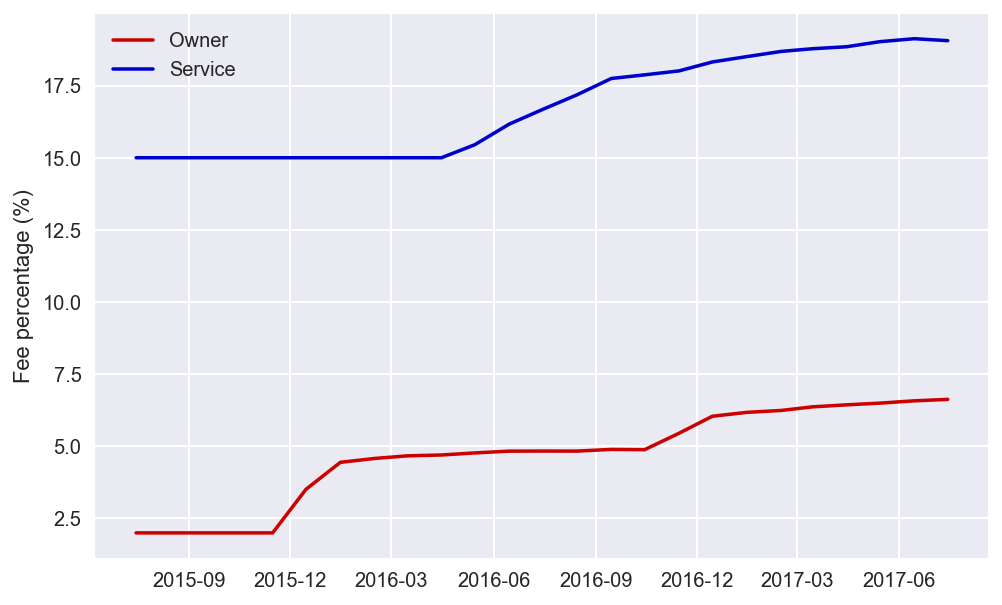

In [72]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
h_1, = ax.plot_date(gb_nr.date, gb_nr.owner_pct*100, linestyle = 'solid', marker = 'None',  color = (0.8,0.0,0.0),
                    label = 'Owner')
h_2, = ax.plot_date(gb_nr.date, gb_nr.service_pct*100, linestyle = 'solid', marker = 'None', color = (0.0,0.0,0.8),
                    label = 'Service')
ax.legend(handles = [h_1, h_2])
ax.set_ylabel('Fee percentage (%)')
fig.set_figheight(5)
fig.set_figwidth(8)
plt.show()

So both the percentage fee charged to owners, and the percentage fee charged to providers have increased over time. Let's see how these are correlated with take rate.

First, we'll scale take rate, owner fee, and service fee to make them easier to compare.

In [73]:
# scaled x = (x - mean(X)) / std(X)
def scale(A):
    A_scl = []
    std = np.std(A)
    mu = np.mean(A)
    for ii in A:
        A_scl.append((ii-mu) / std)
    return A_scl
tr_scl = scale(tr.take_rate/100.0)
owner_scl = scale(gb_nr.owner_pct)
service_scl = scale(gb_nr.service_pct)

Now, we'll scatter our scaled take rate against the scaled owner and service percentages, and also examine how these have changed through time.

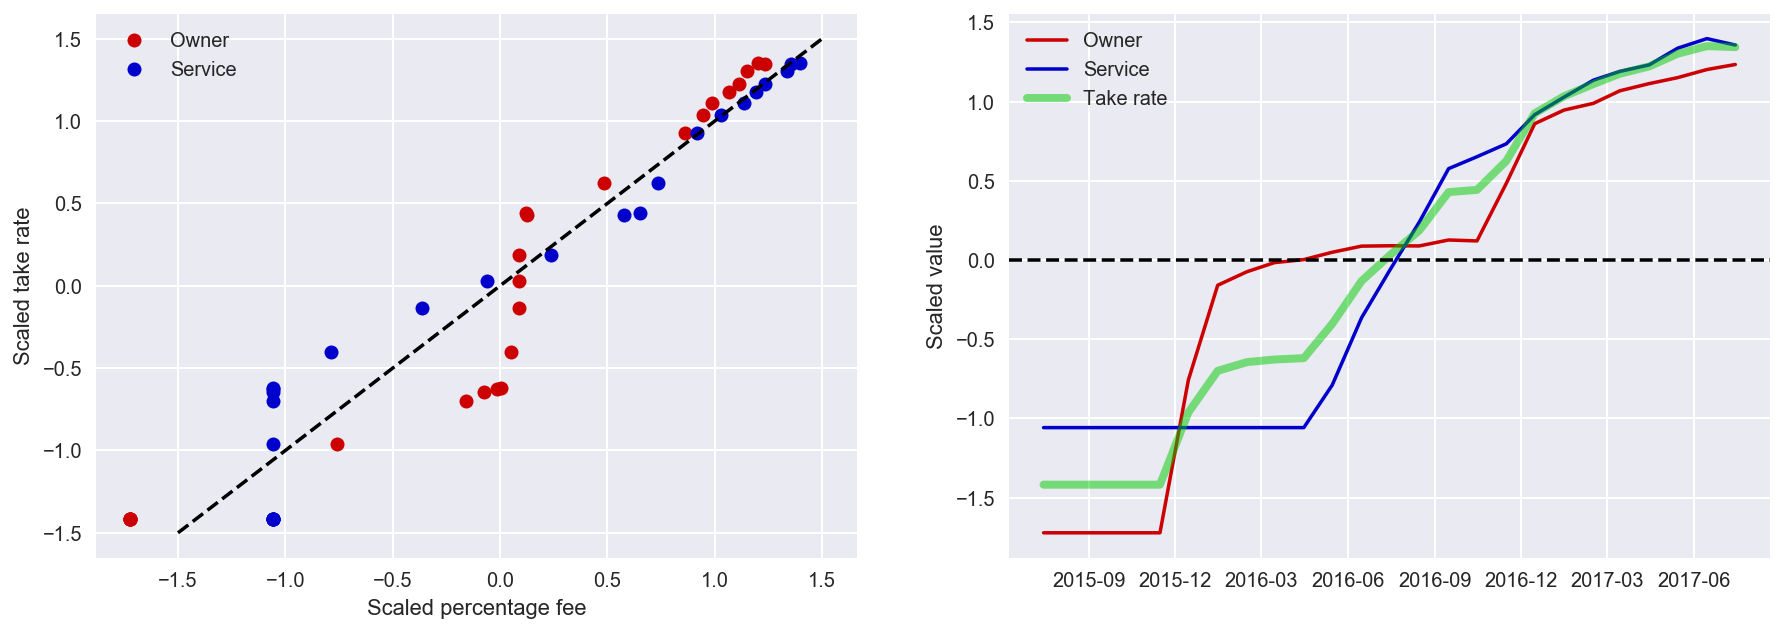

In [74]:
fig, (ax_1, ax_2) = plt.subplots(nrows = 1, ncols = 2)

h_1, = ax_1.plot(owner_scl, tr_scl, linestyle = 'None', marker = 'o', color = (0.8, 0.0, 0.0), label = 'Owner')
h_2, = ax_1.plot(service_scl, tr_scl, linestyle = 'None', marker = 'o', color = (0.0, 0.0, 0.8), label = 'Service')
ax_1.legend(handles = [h_1, h_2])
ax_1.set_xlabel('Scaled percentage fee')
ax_1.set_ylabel('Scaled take rate')
ax_1.plot([-1.5, 1.5], [-1.5, 1.5], color = (0,0,0), linestyle = '--')

h_1, = ax_2.plot_date(gb_nr.date, owner_scl, linestyle = 'solid', marker = 'None', color = (0.8, 0.0, 0.0), 
                      label = 'Owner')
h_2, = ax_2.plot_date(gb_nr.date, service_scl, linestyle = 'solid', marker = 'None', color = (0.0, 0.0, 0.8), 
                      label = 'Service')
h_3, = ax_2.plot_date(gb_nr.date, tr_scl, linestyle = 'solid', marker = 'None', color = (0.0, 0.8, 0.0, 0.5), 
                      linewidth = 4, label = 'Take rate')
ax_2.legend(handles = [h_1, h_2, h_3])
ax_2.set_ylabel('Scaled value')
ax_2.axhline(color = (0,0,0), linestyle = '--')


fig.set_figheight(5)
fig.set_figwidth(15)
plt.show()

We know that this company increased both service and owner fees over time, and these increases drove take rate up. Sometimes these increases occurred concurrently, sometimes they occurred independently. Looking at the first graph, we can see increases in take rate that occurred when owner or service fees remained unchanged (the near-vertical increases). In these cases, the increase in take rate was driven by an increase in the other fee.

Examining these changes over time, we can see the company experiment with different fee structures to increase take rate. Take rate is initially flat, and increases as average owner fee increases. The company then stopped increasing owner fees, and began increasing service fees consistently from April 2016 through June 2017. The rate of service fee increase decreased in October 2016. Owner fees were increased again in November 2016, and continued to increase through June 2017. These cheaper, early rates were likely offered to entice owners and providers to use the platform

***

<br>
<br>
$$\textbf{Section V. New conversation flow}$$

Internal documents indicate that this recently acquired company was performing many A/B tests; we would like to investigate one. This platform had a conversation page where owners and service providers could exchange messages as they organized their booking. The team thought this page could use a re-design and set out to improve its UI. A product manager then set up a test to measure the new page's effectiveness. On 2017-03-13 , an A/B test was launched. For those owners who sent a request, they would be randomly assigned to variant or holdout groups. Those users who are in the variant group would see the new conversation flow. However, those in the holdout group would see the old conversation flow. Providers would always see the old conversation flow.
<br>
<br>


1) Did conversations with the new conversation page book at a higher rate?

In [75]:
query = '''
    SELECT 
        COUNT(*) AS total,
        SUM(CASE WHEN booked_at IS NOT NULL THEN 1 ELSE 0 END) AS booked,
        SUM(CASE WHEN gender = 'f' THEN 1 ELSE 0 END) AS female,
        AVG(units) AS num_pets,
        SUM(CASE WHEN service_type = 'boarding' THEN 1 ELSE 0 END) AS board_count,
        SUM(CASE WHEN service_type = 'day-care' THEN 1 ELSE 0 END) AS day_count,
        SUM(CASE WHEN service_type = 'dog-walking' THEN 1 ELSE 0 END) AS walk_count
    FROM conversations_conversation AS c_c
    LEFT JOIN people_testsegmentation AS p_t
        ON c_c.requester_id = p_t.person_id AND p_t.added = c_c.added
    LEFT JOIN people_person AS p_p
        ON c_c.requester_id = p_p.id
    LEFT JOIN services_service AS s_s
        ON c_c.service_id = s_s.id
    WHERE test_group = 'holdout'
    AND test_name = 'New Conversation Flow'
    AND c_c.added > DATETIME('2017-03-13');
'''
holdout = pd.read_sql(query, conn)

query = '''
    SELECT 
        COUNT(*) AS total,
        SUM(CASE WHEN booked_at IS NOT NULL THEN 1 ELSE 0 END) AS booked,
        SUM(CASE WHEN gender = 'f' THEN 1 ELSE 0 END) AS female,
        AVG(units) AS num_pets,
        SUM(CASE WHEN service_type = 'boarding' THEN 1 ELSE 0 END) AS board_count,
        SUM(CASE WHEN service_type = 'day-care' THEN 1 ELSE 0 END) AS day_count,
        SUM(CASE WHEN service_type = 'dog-walking' THEN 1 ELSE 0 END) AS walk_count
    FROM conversations_conversation AS c_c
    LEFT JOIN people_testsegmentation AS p_t
        ON c_c.requester_id = p_t.person_id AND p_t.added = c_c.added
    LEFT JOIN people_person AS p_p
        ON c_c.requester_id = p_p.id
    LEFT JOIN services_service AS s_s
        ON c_c.service_id = s_s.id
    WHERE test_group = 'variant'
    AND test_name = 'New Conversation Flow'
    AND c_c.added > DATETIME('2017-03-13');
'''
variant = pd.read_sql(query, conn)

In [76]:
variant_br = float(variant.booked / variant.total)
holdout_br = float(holdout.booked / holdout.total)
print('Variant booking rate: ', str(round(variant_br*100, 2)) + '%')
print('Holdout booking rate: ', str(round(holdout_br*100, 2)) + '%')

Variant booking rate:  46.75%
Holdout booking rate:  39.96%


The booking rate with the new conversation flow books at a higher rate.

2) Is it statistically significant?

We will calculate statistical significance using Pearson's $\chi^2$-test

In [77]:
a = [variant.total-variant.booked, variant.booked] # a: variant
b = [holdout.total-holdout.booked, holdout.booked] # b: holdout
_, p_value, _, _ = scipy.stats.chi2_contingency([a, b])
print('p-value: ' + str(p_value))

p-value: 9.66874024288e-26


The p-value is small enough that we can say the result is statistically significant at the >99% confidence level

3) Do you have any reservations about the experiment design? What would you recommend as next steps?

To check that the experiment was designed well, let's make sure that the sample populations ended up with similar demographics. Earlier, we pulled out the number of women (to get a gender split), as well as the average number of units requested (num_pets), and the total number of boarding, day-care, and dog-walking requests.

In [78]:
print('Variant')
display(variant)
print('')
print('')
print('Holdout')
display(holdout)

Variant


,total,booked,female,num_pets,board_count,day_count,walk_count
0,11749,5493,5771,4.264533,3864,3944,3941




Holdout


,total,booked,female,num_pets,board_count,day_count,walk_count
0,11751,4696,5922,4.271126,3945,3906,3900


Those actually look pretty similar between the two test groups. Nothing to indicate that demographic differences are giving a bad result.

From my read, the A/B test was initialized at the point that an owner sent a message after 2017-03-13. This means that users who may have already booked and used services were switched onto the new conversation flow, and counted as part of the 'variant' group. This seems like a poor choice to me. These owners have already shown that they want to use the site's services. A better choice might have been to assign the testing group when a new user signed up for the site, which would isolate owner's with previous experience with the site from the testing pool. We could switch the A/B test to the alternative format, but regardless, the test result seems strong. Moving forward, I would recommend that the company switch to the 'variant' conversation flow.

<br>
<br>
$$\textbf{Section V. Search Engine Marketing}$$

Search engine advertising is a huge driver of new user accounts. Users that are aquired through search engine marketing can be identified by looking at people_person.channel . These users will have 'Google' listed there.
Historically, this company spent an average of \$30 per account to advertise in the 2nd position on Google. However, on 2017-04-12 , they decided to start bidding for the 1st position. Since 2017-04-12 , they have spent \$210,285 in total.
<br>
<br>


1) For each day, determine the count of users that joined and were acquired through Google. Plot this and confirm there is an inflection point on or near
2017-04-12 .

In [79]:
# Select count of users by day where channel is Google
query = '''
    SELECT
        DATE(date_joined) AS date_joined,
        COUNT(*) AS users
    FROM people_person
    WHERE channel = 'Google'
    GROUP BY DATE(date_joined);
'''
user_addition = pd.read_sql(query, conn)

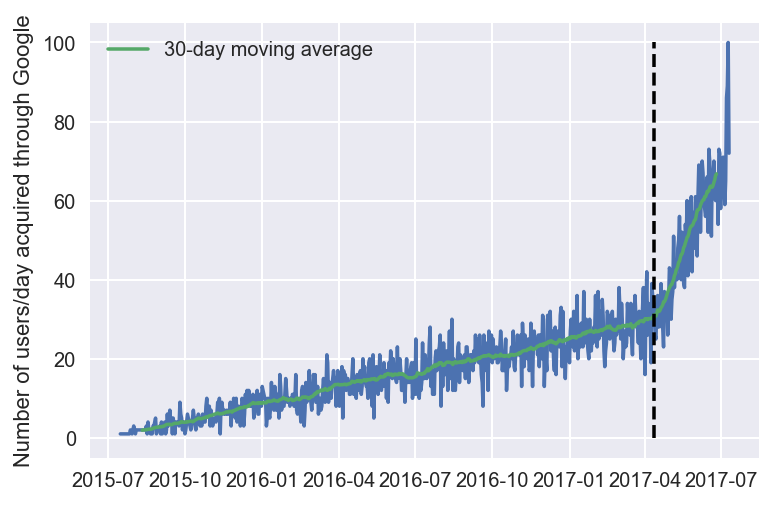

In [80]:
# Plot both the data, and a 30-day moving average
window = 30
mva = np.convolve(user_addition.users, np.ones((window,))/window, mode='valid')
dt_mva = user_addition.date_joined[window//2-1 : -window//2]

plt.plot_date(user_addition.date_joined, user_addition.users, linestyle = 'solid', marker = 'None')
h = plt.plot_date(dt_mva, mva, linestyle = 'solid', marker = 'None', label = str(window) + '-day moving average')
plt.plot_date(['2017-04-12', '2017-04-12'], [0, 100], linestyle = '--', marker = 'None', color = (0,0,0))
plt.legend(handles = h)
plt.ylabel('Number of users/day acquired through Google')
plt.show()

Something definitely happened around 2017-04-12. There is a rapid increase in user acquisitions. Acquisition rate switches from one approximately linear trend to another, steeper one.

2) How many users were acquired via Google advertising since 2017-04-12 and
what was the average cost per account?

In [81]:
# Select count of users acquired via Google since 2017-04-12
query = '''
    SELECT
        COUNT(*) AS users
    FROM people_person
    WHERE channel = 'Google'
    AND date_joined > DATETIME('2017-04-12');
'''
google_count = pd.read_sql(query, conn)
display(google_count)

print('Cost per account : $' + str(int(round(210285 / google_count.users, 0))))

,users
0,4673


Cost per account : $45


4,673 total users have been acquired via Google advertising since 2017-04-12. The company has spent \$210,285 on Google advertising since 2017-04-12, so on average each account cost \$45 to acquire.

3) Estimate how many users would have been acquired had the company not changed its bidding strategy. What would have been the marketing spend in that case?

Let's figure out what the acquisition rate was before 2017-04-12 by fitting a linear model to that time period.

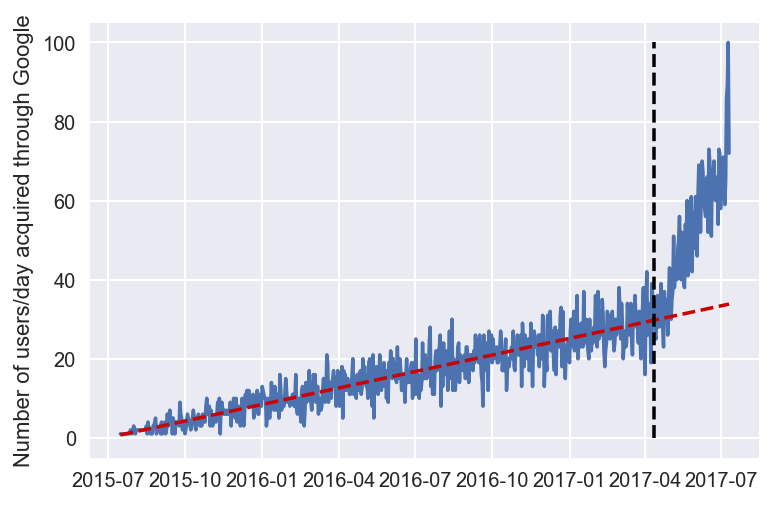

In [82]:
# Creat time vector
t_num = []
for ii in user_addition.date_joined:
    t_num.append(dt.toordinal(dt.strptime(ii, '%Y-%m-%d')))

# Find dates before 2017-04-12
I = t_num.index(dt.toordinal(dt.strptime('2017-04-12', '%Y-%m-%d')))

# Fit a first order polynomial function using NumPy
z = np.polyfit(t_num[:I], user_addition.users[:I], 1)
p = np.poly1d(z)

# Plot to show fit
plt.plot_date(user_addition.date_joined, user_addition.users, linestyle = 'solid', marker = 'None')
plt.plot_date(user_addition.date_joined, p(t_num), linestyle = '--', marker = 'None',  color = (0.8, 0.0, 0.0))
plt.plot_date(['2017-04-12', '2017-04-12'], [0, 100], linestyle = '--', marker = 'None', color = (0,0,0))
plt.ylabel('Number of users/day acquired through Google')
plt.show()

Now, we integrate the area under this line from 2017-04-12 and 2017-07-10 to determine the total number of users during that period

In [103]:
# Integrate to find total users
users = 0.5*(p(t_num[-1]) + p(t_num[I]))*(t_num[-1] - t_num[I])
print(str(int(round(users, 0))) + ' users')

# Multiply by price per account
print('Marketing spend: $' + str(int(users*30)))

2830 users
Marketing spend: $84898


If the company had stayed with the first strategy, they would have added approximately 2,830 users over that period.

4) How many additional accounts were created? What was the marginal cost per account for these additional accounts?

We established in question 2 that 4,673 users were added at a cost of \$210,285 through Google since 2017-04-12, when the company started bidding for first position. If they had stayed in second position, they would have added 2,830 users at a cost of \$84,900.

But what did they spend per account to gain these additional accounts?

Marginal cost is defined as the derivative of cost with respect to quantity. We can discretize this:
$$MC = \frac{\delta C}{\delta Q} = \frac{\Delta C}{\Delta Q}$$
So our marginal cost is the change in cost divided by the change in users.

In [114]:
# Subtract the total cost incurred if they had stayed at position 2 from the actual cost to find the total extra
# cost incurred
cost_additional = 210285 - users*30

# Then subtract the number of users that would have been added at position 2 from the actual number of added users
# to find the number of additional users added by switching
users_additional = float(google_count.users) - users

# Now divide the additional cost by the additional users to find the marginal cost per unit
marginal_cost = cost_additional / users_additional

print('Marginal cost: $' + str(round(marginal_cost, 2)))

Marginal cost: $68.03
